# 简单理解 Density Fitting RMP2

> 创建时间：2019-10-16

这一节的内容承接上一节对 DF RHF 的理解，只是简单地近一步得到 RMP2 的能量。

In [1]:
%matplotlib notebook

import numpy as np
import scipy
from functools import partial
import matplotlib.pyplot as plt

from pyscf import gto, scf, mp, df

np.einsum = partial(np.einsum, optimize=["greedy", 1024 ** 3 * 2 / 8])
np.set_printoptions(8, linewidth=150, suppress=True)

我们使用的体系仍然是不对称的双氧水分子：

In [2]:
mol = gto.Mole()
mol.atom = """
O  0.0  0.0  0.0
O  0.0  0.0  1.5
H  1.0  0.0  0.0
H  0.0  0.7  1.0
"""
mol.basis = "def2-tzvp"
mol.verbose = 0
mol.build()

natm = mol.natm
nao = nmo = mol.nao
nocc = mol.nelec[0]
nvir = nmo - nocc
so, sv, sa = slice(0, nocc), slice(nocc, nmo), slice(0, nmo)

## PySCF RMP2

### PySCF 普通 RMP2

在我们跑 DF RMP2 前，我们先跑一下普通的 RMP2，以作对比。

In [3]:
scf_normal = scf.RHF(mol).run()
mp2_normal = mp.MP2(scf_normal).run()
mp2_normal.e_corr

-0.5378068680460026

### PySCF DF RHF

在 PySCF 中，即使自洽场已经经过 DF 优化过，也不需要特别地对 MP2 的代码作改变：

In [4]:
scf_df = scf.RHF(mol).density_fit().run()
mp2_df = mp.MP2(scf_df).run()
mp2_df.e_corr

-0.5370249637959694

在相关能上，两者的结果还是稍有差距的。

In [5]:
mp2_df.e_corr - mp2_normal.e_corr

0.0007819042500332163

对于 PySCF 而言，一种更好的做法是，在自洽场过程中使用对 J/K 积分优化较好的 `jkfit` 型 DF 基组，而在 MP2 或后自洽场中使用对 MP2 优化较好的 `ri` 型 DF 基组：

In [6]:
scf_df = scf.RHF(mol).density_fit(auxbasis="def2-tzvp-jkfit").run()
mp2_df = mp.MP2(scf_df).density_fit(auxbasis="def2-tzvp-ri").run()
mp2_df.e_corr

-0.5377072684090778

现在相关能的误差就相对来说小了不少。

In [7]:
mp2_df.e_corr - mp2_normal.e_corr

9.959963692485196e-05

## 重现 PySCF DF RMP2 相关能

### DF 基组定义与必要张量

我们首先生成计算 DF RMP2 所需要的张量：

* `V_df_mp2` $V_{\mu \nu, P}^\mathrm{MP2}$：经过 Cholesky 处理的三中心双电子张量

* `C`, `Co`, `Cv` $C_{\mu p}$：分子轨道系数 `C`，以及其在占据轨道 (`Co`)、非占轨道 (`Cv`) 的分割

* `D_iajb` $D_{ij}^{ab}$：即 $\varepsilon_i - \varepsilon_a + \varepsilon_j - \varepsilon_b$

我们指出，这里计算的 `V_df_mp2` $V_{\mu \nu, P}^\mathrm{MP2}$ 是由 RI 基组 `def2-tzvp-ri` 产生；与上一篇文档提到的由 `def2-tzvp-jkfit` 所生成的 $V_{\mu \nu, P}$ 是不同的。因此，我们需要使用对应的 `def2-tzvp-ri` 基组来产生 DF 分子类 `auxmol`。

In [8]:
auxmol = mol.copy()
auxmol.basis = "def2-tzvp-ri"
auxmol.build()

nao_df = auxmol.nao

In [9]:
int2c2e = auxmol.intor("int2c2e")
int2c2e.shape
int3c2e = df.incore.aux_e2(mol, auxmol)

int2c2e_half = scipy.linalg.cholesky(int2c2e, lower=True)
V_df_mp2 = scipy.linalg.solve_triangular(int2c2e_half, int3c2e.reshape(-1, nao_df).T, lower=True)\
               .reshape(nao_df, nao, nao).transpose((1, 2, 0))

In [10]:
C, e = scf_df.mo_coeff, scf_df.mo_energy
Co, Cv = C[:, so], C[:, sv]
eo, ev = e[so], e[sv]
D_iajb = eo[:, None, None, None] - ev[None, :, None, None] + eo[None, None, :, None] - ev[None, None, None, :]

### ERI 积分转换

MP2 中最为耗时的一步是原子轨道 4c2e 的 ERI 积分 $(\mu \nu | \kappa \lambda)$ 转换为分子轨道 $(ia|jb)$ 的过程。我们在 DF MP2 中仍然没有避开生成 $(ia|jb)$，但我们避开了直接生成 $(\mu \nu | \kappa \lambda)$；恰恰是这一步成为 DF MP2 的优势。其具体的过程大致如下。

首先，我们生成分子轨道下的三中心积分 $V_{ia, P}^\mathrm{MP2}$ `V_df_ia` ($O(N^4)$ 复杂度)：

$$
V_{ia, P}^\mathrm{MP2} = V_{\mu \nu, P}^\mathrm{MP2} C_{\mu i} C_{\nu p}
$$

In [11]:
V_df_ia = np.einsum("uvP, ui, va -> iaP", V_df_mp2, Co, Cv)

尽管我们使用了与 `jkfit` 不同的基组，但我们仍然认为 $(\mu \nu | \kappa \lambda) \simeq V_{\mu \nu, P}^\mathrm{MP2} V_{\kappa \lambda, P}^\mathrm{MP2}$ 近似成立。因此，我们可以很容易地给出 ($O(N^5)$ 复杂度)

$$
\begin{align*}
(ia|jb) &= C_{\mu i} C_{\nu a} (\mu \nu | \kappa \lambda) C_{\kappa j} C_{\lambda b} \\
&\simeq C_{\mu i} C_{\nu a} V_{\mu \nu, P}^\mathrm{MP2} V_{\kappa \lambda, P}^\mathrm{MP2} C_{\kappa j} C_{\lambda b} \\
&\simeq V_{ia, P}^\mathrm{MP2} V_{jb, P}^\mathrm{MP2}
\end{align*}
$$

In [12]:
eri_df_iajb = np.einsum("iaP, jbP -> iajb", V_df_ia, V_df_ia)

当然，我们也可以使用下述代码，一次性地从 $V_{\mu \nu, P}^\mathrm{MP2}$ 生成 DF 近似的 $(ia|jb)$ `eri_df_iajb`，而结果和效率没有任何影响：

In [13]:
np.allclose(
    np.einsum("ui, va, uvP, klP, kj, lb -> iajb", Co, Cv, V_df_mp2, V_df_mp2, Co, Cv),
    eri_df_iajb
)

True

最后，我们通过图像指出，DF 近似的转换后的分子轨道 ERI 与普通的分子轨道 ERI 非常接近。

In [14]:
eri = mol.intor("int2e")
eri_iajb = np.einsum("ui, va, uvkl, kj, lb -> iajb", Co, Cv, eri, Co, Cv)

In [15]:
bins =np.arange(-12, 1., 0.1)
histo_eri = np.histogram(np.log10(np.abs(eri_iajb).ravel() + 1e-20), bins=bins)
histo_df_eri = np.histogram(np.log10(np.abs(eri_df_iajb).ravel() + 1e-20), bins=bins)
histo_dev = np.histogram(np.log10(np.abs(eri_df_iajb - eri_iajb).ravel() + 1e-20), bins=bins)

prob_eri = histo_eri[0] / eri_iajb.size
prob_df_eri = histo_df_eri[0] / eri_iajb.size
prob_dev = histo_dev[0] / eri_iajb.size

<IPython.core.display.Javascript object>


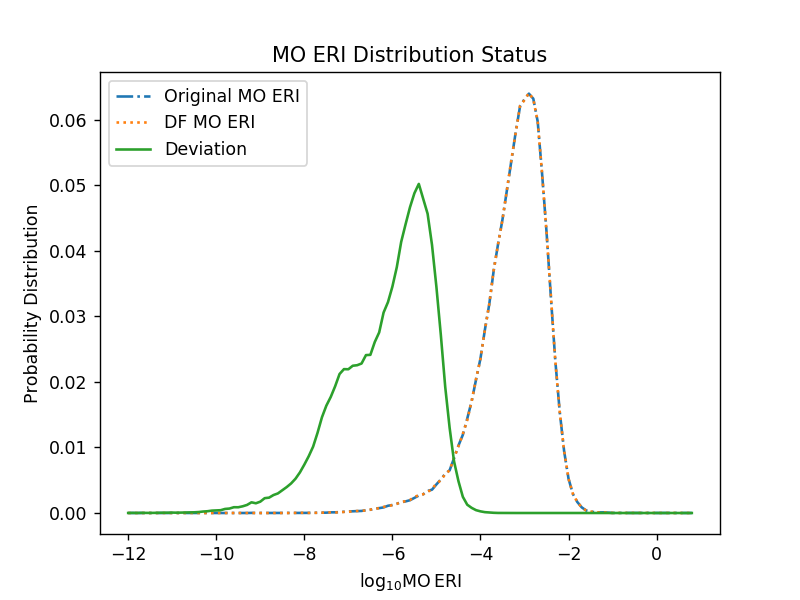

In [16]:
fig, ax = plt.subplots()

ax.plot(histo_eri[1][:-1], prob_eri, label="Original MO ERI", linestyle="-.")
ax.plot(histo_df_eri[1][:-1], prob_df_eri, label="DF MO ERI", linestyle=":")
ax.plot(histo_dev[1][:-1], prob_dev, label="Deviation")

ax.set_xlabel("$\mathrm{log}_{10} \mathrm{MO\, ERI}$")
ax.set_ylabel("Probability Distribution")
ax.set_title("MO ERI Distribution Status")
ax.legend()

上图中，蓝色线是普通的 MO ERI，它与橙色线几乎重合，意味着两者数值上极为相近。同时，作为两者之差的绿色线的分布明显在更小的数量级上。

### 积分转换的复杂度简单分析

上述的复杂度是不难分析的。尽管 DF 与普通 MP2 所进行的积分转换都是 $O(N^5)$ 的复杂度；但细致地分析会发现，普通 MP2 的复杂度是 $O(n_\mathrm{occ} n_\mathrm{AO}^4)$，而 DF 的复杂度是 $O(n_\mathrm{occ}^2 n_\mathrm{vir}^2 n_\mathrm{aux})$，两者的计算次数是远不相同的。

我们有 `einsum_path` 的工具；通过该工具的 `Optimized FLOP count` 输出，我们能知道实际上 NumPy 将会计算多少次浮点计算。同时，`Largest intermediate` 会告诉我们在当前的张量缩并路径下，内存中需要使用的最大的中间张量大小。

下述的缩并过程是普通 MP2 的分子轨道基组 ERI 计算过程

$$
(ia|jb) = C_{\mu i} C_{\nu a} (\mu \nu | \kappa \lambda) C_{\kappa j} C_{\lambda b}
$$

若使用朴素的 (Naive) 张量乘积 ($O(N^8)$ 复杂度)，那么需要进行 $5.131 \times 10^{13}$ 次浮点计算。我们知道通常的 MP2 是 $O(N^5)$ 复杂度；其对应的浮点计算次数在当前的双氧水体系下是 $7.137 \times 10^8$ 次。

In [17]:
print(np.einsum_path("ui, va, uvkl, kj, lb -> iajb", Co, Cv, mol.intor("int2e"), Co, Cv, optimize=True)[1])

  Complete contraction:  ui,va,uvkl,kj,lb->iajb
         Naive scaling:  8
     Optimized scaling:  5
      Naive FLOP count:  5.131e+13
  Optimized FLOP count:  7.137e+08
   Theoretical speedup:  71892.409
  Largest intermediate:  3.647e+06 elements
--------------------------------------------------------------------------
scaling                  current                                remaining
--------------------------------------------------------------------------
   5               uvkl,ui->iklv                      va,kj,lb,iklv->iajb
   5               iklv,kj->ijlv                         va,lb,ijlv->iajb
   5               ijlv,va->ijal                            lb,ijal->iajb
   5               ijal,lb->iajb                               iajb->iajb


而在 DF 近似于优化下，

$$
(ia|jb) \simeq C_{\mu i} C_{\nu a} V_{\mu \nu, P}^\mathrm{MP2} V_{\kappa \lambda, P}^\mathrm{MP2} C_{\kappa j} C_{\lambda b}
$$

其对应的浮点计算次数则是 $1.920 \times 10^8$。可以看到，DF 速度提升大约 3.72 倍。除此之外，积分转换对内存空间的需求还是普通 MP2 的 1/10.66 倍，因此可以说 DF MP2 是在损失比较小的精度的前提下，同时提升计算效率与内存利用，是一个很好的 Balance。

In [18]:
print(np.einsum_path("ui, va, uvP, klP, kj, lb -> iajb", Co, Cv, V_df_mp2, V_df_mp2, Co, Cv, optimize=True)[1])

  Complete contraction:  ui,va,uvP,klP,kj,lb->iajb
         Naive scaling:  9
     Optimized scaling:  5
      Naive FLOP count:  1.121e+16
  Optimized FLOP count:  1.920e+08
   Theoretical speedup:  58377026.800
  Largest intermediate:  3.422e+05 elements
--------------------------------------------------------------------------
scaling                  current                                remaining
--------------------------------------------------------------------------
   4                 uvP,ui->ivP                   va,klP,kj,lb,ivP->iajb
   4                 kj,klP->jlP                      va,lb,ivP,jlP->iajb
   4                 ivP,va->iaP                         lb,jlP,iaP->iajb
   4                 jlP,lb->jbP                            iaP,jbP->iajb
   5               jbP,iaP->iajb                               iajb->iajb


### DF MP2 相关能

既然我们已经获得了 DF 近似的 $(ia|jb)$，那么后面的过程与普通的 MP2 并无差异：

* $t_{ij}^{ab} = (ia|jb) / D_{ij}^{ab}$

* $T_{ij}^{ab} = 2 t_{ij}^{ab} - t_{ij}^{ba}$

* $E_\mathrm{MP2, corr} = T_{ij}^{ab} t_{ij}^{ab} D_{ij}^{ab}$

In [19]:
t_iajb = eri_df_iajb / D_iajb
T_iajb = (2 * t_iajb - t_iajb.swapaxes(-1, -3))
mp2_df_corr = (T_iajb * t_iajb * D_iajb).sum()
mp2_df_corr

-0.5377072684090779

我们可以看到计算得到的 DF MP2 能量与 PySCF 所给出的 DF MP2 能量几乎完全相等。

In [20]:
mp2_df_corr - mp2_df.e_corr

-1.1102230246251565e-16